In [1]:
"""
Created on Tue Mar 9 2021
@author: Nicole Albern

Plot vertical profiles of w, temp and qv for each
cloud class.
"""

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('/pf/b/b380490/jupyter_notebooks/nawdex_hackathon')
import dict_nawdexsims

simdict = dict_nawdexsims.simdictionary()
colordict = dict_nawdexsims.colordictionary()

#import dask
#from dask.distributed import Client
#client = Client()
#client

In [2]:
# get height at full levels
def get_fulllevel_height():
    # define simulation
    resolution = '80km'
    sim = '0001'
    expid = 'nawdexnwp-' + resolution + '-mis-' + sim

    # read ocean mask
    ipath_oceanmask = '/work/bb1018/nawdex-hackathon_pp/'
    da_ocean = xr.open_dataset(ipath_oceanmask + '/openoceanmask/' + expid + \
                               '_openoceanmask.nc')['mask_openocean']
    index = np.where(da_ocean == 1)[0]
    del da_ocean, ipath_oceanmask

    # read z_ifc data
    ipath = '/work/bb1018/b380459/NAWDEX/ICON_OUTPUT_NWP/' + \
            'nawdexnwp-' + resolution + '-mis-' + sim + '/'
    ds = xr.open_dataset(ipath + 'nawdexnwp-' + resolution + '-mis-' + \
                         sim + '_2016092200_fg_DOM01_ML_0036.nc')
    del ipath

    # apply ocean mask on z_ifc to make sure to look at ocean grid point
    ds = ds.isel(ncells=index)

    # calculate full levels based on z_ifc
    z_full = (ds.z_ifc[:,0] - (ds.z_ifc[:,0].diff('height_3')/2)).values

    #print(z_full)
    
    # get half level height
    z_half = ds.z_ifc[:, 0].values

    del resolution, sim, expid, index, ds
    
    return z_full, z_half

zfull, zhalf = get_fulllevel_height()

#print(zfull.shape, zhalf.shape)
#print(zfull)
#print(zhalf)

In [3]:
# thresholds for cloud classes
# 'hq62_mq67_lq30', 'hq60_mq60_lq25', 'hq65_mq70_lq35'
threshold = 'hq62_mq67_lq30'

#ipath = '/scratch/b/b380490/hackathon/'
ipath = '/work/bb1018/nawdex-hackathon_pp/cloudclasses/' + \
        'w_temp_qv_for_cloudclass/'# + threshold + '/'
opath = '/pf/b/b380490/jupyter_notebook_output/nawdex_hackathon/'

# simulation setups
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
mphysics = [1, 2]
#conv = 1

# cloud classes
ncclass = 8 # number of cloud classes
cclasses = ['High (H)', 'Middle (M)', 'Low (L)',
            'H-M', 'M-L', 'H-L', 'H-M-L', 'clear sky']
cclass_save = ['H', 'M', 'L', 'H-M', 'M-L', 'H-L', 'H-M-L', 'clearsky']

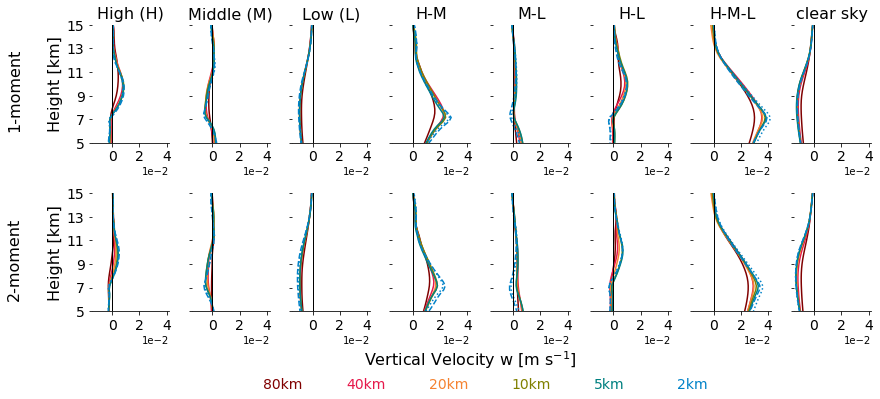

In [4]:
# Overview plots - vertical wind w
# all classes, all heights, both microphysics schemes in one figure

var = 'w'

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(2, 8, figsize=(11.5, 5), sharey=True)
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]
        #print(expids)

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                 '_w_temp_qv_cloudclasses_' + \
                                 'areamean_timemean_oceanmask_applied_' + \
                                 threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        #print(ds)

        del data, expid

        # plot cloud cover for different cloud classes
        for c in range(ncclass):#-1):
            ax[mphys-1, c].plot(ds[var + '_cclass' + str(c+1)], zhalf/1000,
                                color=colordict[res], linestyle=lstyle, label=res)
            ax[mphys-1, c].tick_params(labelsize=14)
            ax[mphys-1, c].spines['right'].set_color('none')
            ax[mphys-1, c].spines['top'].set_color('none')
            ax[mphys-1, c].spines['left'].set_color('none')
            #ax[mphys-1, c].spines['left'].set_position('zero')
            ax[mphys-1, c].axvline(0, linewidth=1, color='k')
            ax[mphys-1, c].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, c].set_ylim(5, 15)# (5, 15)#(0, 17)
            if ax[mphys-1, c].get_ylim() == (0.0, 17.0):
                ax[mphys-1, c].axhline(5, linewidth=1, color='k')
                ax[mphys-1, c].axhline(15, linewidth=1, color='k')
            ax[mphys-1, c].ticklabel_format(axis='x', scilimits=(-2,-2))
            ax[mphys-1, c].set_xticks(np.arange(-2e-2, 5e-2, 2e-2)) #5e-3))
            ax[mphys-1, c].set_xlim(-1.5e-2, 4.2e-2)
            # for 5-15 km:
            #if ax[mphys-1, c].get_ylim() == (5.0, 15.0):
            #    ax[mphys-1, c].set_xlim(-0.2, 0.55)
            ## for 0-17 km:
            #elif ax[mphys-1, c].get_ylim() == (0.0, 17.0):
            #    ax[mphys-1, c].set_xlim(-0.4, 0.55)
            ax[0, c].set_title(cclasses[c], fontsize=16)
        del c
        del ds
    del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

#leg = ax[.legend(ncol=1, prop={'size':15})
##leg.get_frame().set_linewidth(0.0)
##del leg

ax[0, 0].set_ylabel('Height [km]', fontsize=16)
ax[1, 0].set_ylabel('Height [km]', fontsize=16)
#fig.text(-0.02, 0.5, 'Height [km]', rotation='vertical',
#         ha='center', va='center', fontsize=16)
fig.text(0.5, -0.01, 'Vertical Velocity w [m s$^{-1}$]',
         rotation='horizontal', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.74, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.27, '2-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)

#if ax[0, 0].get_ylim() == (5.0, 15.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_5-15km.png', dpi=400, #pdf',
#                bbox_inches='tight')
#elif ax[0, 0].get_ylim() == (0.0, 17.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_0-17km.png', dpi=400, #pdf',
#                bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax

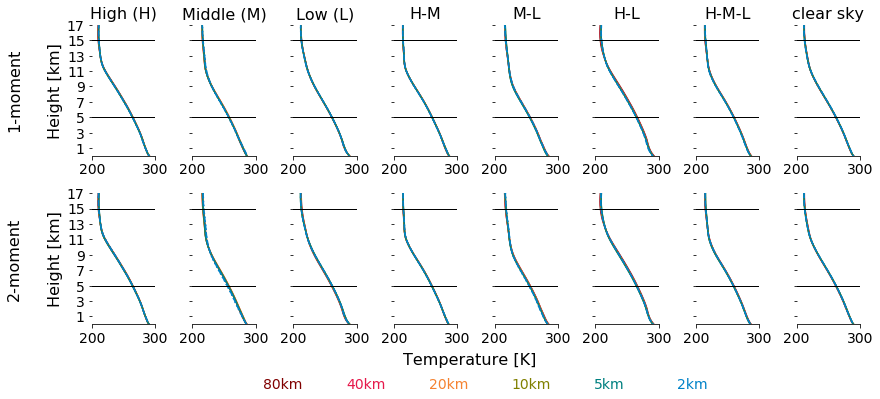

In [43]:
# Overview plots - temperature
# all classes, all heights, both microphysics schemes in one figure

var = 'temp'

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(2, 8, figsize=(11.5, 5), sharey=True)
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]
        #print(expids)

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                 '_w_temp_qv_cloudclasses_' + \
                                 'areamean_timemean_oceanmask_applied_' + \
                                 threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        #print(ds)

        del data, expid

        # plot cloud cover for different cloud classes
        for c in range(ncclass):#-1):
            ax[mphys-1, c].plot(ds[var + '_cclass' + str(c+1)], zfull/1000,
                                color=colordict[res], linestyle=lstyle, label=res)
            ax[mphys-1, c].tick_params(labelsize=14)
            ax[mphys-1, c].spines['right'].set_color('none')
            ax[mphys-1, c].spines['top'].set_color('none')
            ax[mphys-1, c].spines['left'].set_color('none')
            #ax[mphys-1, c].spines['left'].set_position('zero')
            ax[mphys-1, c].axvline(0, linewidth=1, color='k')
            ax[mphys-1, c].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, c].set_ylim(5, 15)# (5, 15)#(0, 17)
            if ax[mphys-1, c].get_ylim() == (0.0, 17.0):
                ax[mphys-1, c].axhline(5, linewidth=1, color='k')
                ax[mphys-1, c].axhline(15, linewidth=1, color='k')
            # for 5-15 km:
            if ax[mphys-1, c].get_ylim() == (5.0, 15.0):
                ax[mphys-1, c].set_xlim(200, 270)
            # for 0-17 km:
            elif ax[mphys-1, c].get_ylim() == (0.0, 17.0):
                ax[mphys-1, c].set_xlim(200, 300)
            ax[0, c].set_title(cclasses[c], fontsize=16)
        del c
        del ds
    del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

#leg = ax[.legend(ncol=1, prop={'size':15})
##leg.get_frame().set_linewidth(0.0)
##del leg

ax[0, 0].set_ylabel('Height [km]', fontsize=16)
ax[1, 0].set_ylabel('Height [km]', fontsize=16)
#fig.text(-0.02, 0.5, 'Height [km]', rotation='vertical',
#         ha='center', va='center', fontsize=16)
fig.text(0.5, -0.01, 'Temperature [K]',
         rotation='horizontal', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.74, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.27, '2-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)

#if ax[0, 0].get_ylim() == (5.0, 15.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_5-15km.png', dpi=400, #pdf',
#                bbox_inches='tight')
#elif ax[0, 0].get_ylim() == (0.0, 17.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_0-17km.png', dpi=400, #pdf',
#                bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax

In [ ]:
# Overview plots - specific humidity qv
# all classes, all heights, both microphysics schemes in one figure

var = 'qv'

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(2, 8, figsize=(11.5, 5), sharey=True)
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]
        #print(expids)

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                 '_w_temp_qv_cloudclasses_' + \
                                 'areamean_timemean_oceanmask_applied_' + \
                                 threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        #print(ds)

        del data, expid

        # plot cloud cover for different cloud classes
        for c in range(ncclass):#-1):
            ax[mphys-1, c].plot(ds[var + '_cclass' + str(c+1)], zfull/1000,
                                color=colordict[res], linestyle=lstyle, label=res)
            ax[mphys-1, c].tick_params(labelsize=14)
            ax[mphys-1, c].spines['right'].set_color('none')
            ax[mphys-1, c].spines['top'].set_color('none')
            ax[mphys-1, c].spines['left'].set_color('none')
            #ax[mphys-1, c].spines['left'].set_position('zero')
            ax[mphys-1, c].axvline(0, linewidth=1, color='k')
            ax[mphys-1, c].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, c].set_ylim(5, 15)# (5, 15)#(0, 17)
            if ax[mphys-1, c].get_ylim() == (0.0, 17.0):
                ax[mphys-1, c].axhline(5, linewidth=1, color='k')
                ax[mphys-1, c].axhline(15, linewidth=1, color='k')
            ax[mphys-1, c].ticklabel_format(axis='x', scilimits=(-3,-3))
            ax[mphys-1, c].set_xticks(np.arange(0, 10e-3, 2e-3)) #5e-3))
            #ax[mphys-1, c].set_xlim(0, 4.2e-3)
            # for 5-15 km:
            if ax[mphys-1, c].get_ylim() == (5.0, 15.0):
                ax[mphys-1, c].set_xlim(0, 2.2e-3)
            # for 0-17 km:
            elif ax[mphys-1, c].get_ylim() == (0.0, 17.0):
                ax[mphys-1, c].set_xlim(0, 8e-3)
            ax[0, c].set_title(cclasses[c], fontsize=16)
        del c
        del ds
    del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

#leg = ax[.legend(ncol=1, prop={'size':15})
##leg.get_frame().set_linewidth(0.0)
##del leg

ax[0, 0].set_ylabel('Height [km]', fontsize=16)
ax[1, 0].set_ylabel('Height [km]', fontsize=16)
#fig.text(-0.02, 0.5, 'Height [km]', rotation='vertical',
#         ha='center', va='center', fontsize=16)
fig.text(0.5, -0.01, 'Specific Humidity [kg kg$^{-1}$]',
         rotation='horizontal', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.74, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.27, '2-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)

#if ax[0, 0].get_ylim() == (5.0, 15.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_5-15km.png', dpi=400, #pdf',
#                bbox_inches='tight')
#elif ax[0, 0].get_ylim() == (0.0, 17.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_0-17km.png', dpi=400, #pdf',
#                bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax

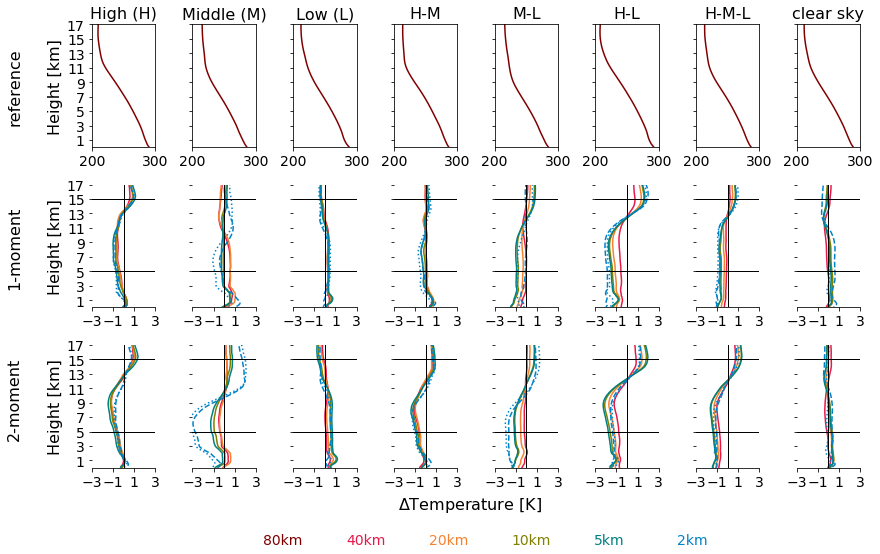

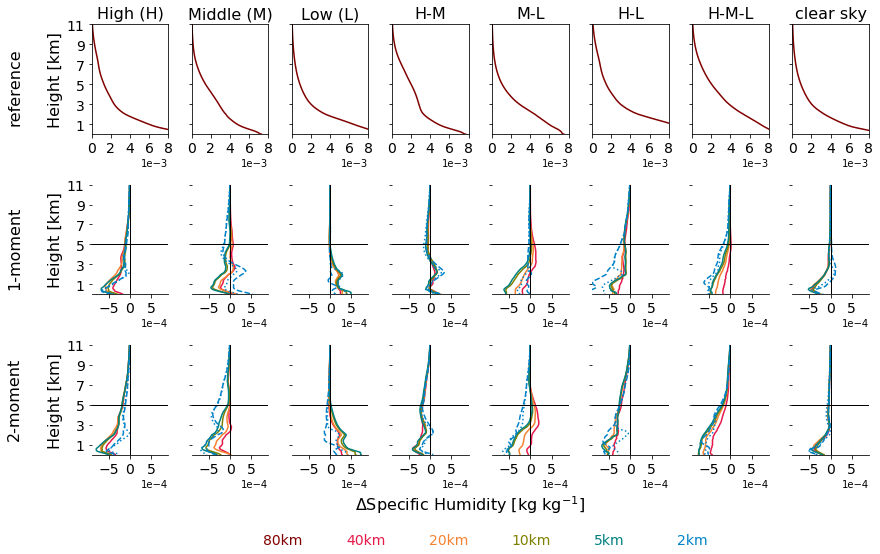

In [49]:
# Temperature and relative humidity relative to reference simulation (80km simulation)
# all classes, all heights, both microphysics schemes in one figure

# read reference simulation
# microphysics = 1
expids = [key for key in simdict if simdict[key]['res'] == '80km' and \
                                    simdict[key]['conv'] == 1 and \
                                    simdict[key]['mphys'] == 1]
# read variable from all simulations that have the same configuration
data = []
for expid in expids:
    ds = xr.open_dataset(ipath + expid + \
                         '_w_temp_qv_cloudclasses_' + \
                         'areamean_timemean_oceanmask_applied_' + \
                         threshold + '.nc')
    data.append(ds)
    del ds
del expid
# merge data and get mean over simulations
ds_ref_mphy1 = xr.concat([x for x in data], 'nsim')
ds_ref_mphy1 = ds_ref_mphy1.mean('nsim')
del data, expids

# microphysics = 2
expids = [key for key in simdict if simdict[key]['res'] == '80km' and \
                                    simdict[key]['conv'] == 1 and \
                                    simdict[key]['mphys'] == 2]
# read variable from all simulations that have the same configuration
data = []
for expid in expids:
    ds = xr.open_dataset(ipath + expid + \
                         '_w_temp_qv_cloudclasses_' + \
                         'areamean_timemean_oceanmask_applied_' + \
                         threshold + '.nc')
    data.append(ds)
    del ds
del expid
# merge data and get mean over simulations
ds_ref_mphy2 = xr.concat([x for x in data], 'nsim')
ds_ref_mphy2 = ds_ref_mphy2.mean('nsim')
del data, expids


var = 'temp'

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(3, 8, figsize=(11.5, 7), sharey=True)
# plot values for reference simulation
for c in range(ncclass):#-1):
    ax[0, c].plot(ds_ref_mphy1[var + '_cclass' + str(c+1)], zfull/1000,
                               color=colordict['80km'], linestyle='-')
#    ax[0, c].plot(ds_ref_mphy2[var + '_cclass' + str(c+1)], zfull/1000,
#                               color=colordict['80km'], linestyle='--')
    ax[0, c].tick_params(labelsize=14)
    ax[0, c].set_xlim(200, 300)
del c

# plot difference to 80km simulation
for mphys in mphysics:
    for res in resolutions[1:]:
        if res in ['40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]
        #print(expids)

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                 '_w_temp_qv_cloudclasses_' + \
                                 'areamean_timemean_oceanmask_applied_' + \
                                 threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        #print(ds)

        del data, expid

        # plot cloud cover for different cloud classes
        for c in range(ncclass):#-1):
            if mphys == 1:
                ax[mphys, c].plot(ds[var + '_cclass' + str(c+1)] - \
                                  ds_ref_mphy1[var + '_cclass' + str(c+1)],
                                  zfull/1000,
                                  color=colordict[res], linestyle=lstyle, label=res)
            elif mphys == 2:
                ax[mphys, c].plot(ds[var + '_cclass' + str(c+1)] - \
                                  ds_ref_mphy1[var + '_cclass' + str(c+1)],
                                  zfull/1000,
                                  color=colordict[res], linestyle=lstyle, label=res)
            ax[mphys, c].tick_params(labelsize=14)
            ax[mphys, c].spines['right'].set_color('none')
            ax[mphys, c].spines['top'].set_color('none')
            ax[mphys, c].spines['left'].set_color('none')
            #ax[mphys-1, c].spines['left'].set_position('zero')
            ax[mphys, c].axvline(0, linewidth=1, color='k')
            ax[mphys, c].set_yticks(np.arange(1, 31, 2))
            ax[mphys, c].set_ylim(0,17)# (5, 15)#(0, 17)
            if ax[mphys, c].get_ylim() == (0.0, 17.0):
                ax[mphys, c].axhline(5, linewidth=1, color='k')
                ax[mphys, c].axhline(15, linewidth=1, color='k')
            # for 5-15 km:
            if ax[mphys, c].get_ylim() == (5.0, 15.0):
                ax[mphys, c].set_xlim(-3, 3)
                ax[mphys, c].set_xticks(np.arange(-3, 4, 2))
            # for 0-17 km:
            elif ax[mphys, c].get_ylim() == (0.0, 17.0):
                ax[mphys, c].set_xlim(-3, 3)
                ax[mphys, c].set_xticks(np.arange(-3, 4, 2))
            ax[0, c].set_title(cclasses[c], fontsize=16)
        del c
        del ds
    del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

#leg = ax[.legend(ncol=1, prop={'size':15})
##leg.get_frame().set_linewidth(0.0)
##del leg

ax[0, 0].set_ylabel('Height [km]', fontsize=16)
ax[1, 0].set_ylabel('Height [km]', fontsize=16)
ax[2, 0].set_ylabel('Height [km]', fontsize=16)
#fig.text(-0.02, 0.5, 'Height [km]', rotation='vertical',
#         ha='center', va='center', fontsize=16)
fig.text(0.5, -0.01, '$\Delta$Temperature [K]',
         rotation='horizontal', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.82, 'reference', rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.5, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.2, '2-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)

#if ax[0, 0].get_ylim() == (5.0, 15.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_relativeto80km_5-15km.png', dpi=400, #pdf',
#                bbox_inches='tight')
#elif ax[0, 0].get_ylim() == (0.0, 17.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_relativeto80km_0-17km.pdf',# dpi=400, #pdf',
#                bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax

del var
###############################################################################
###############################################################################
# specific humidity qv
var = 'qv'

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(3, 8, figsize=(11.5, 7), sharey=True)
# plot values for reference simulation
for c in range(ncclass):#-1):
    ax[0, c].plot(ds_ref_mphy1[var + '_cclass' + str(c+1)], zfull/1000,
                               color=colordict['80km'], linestyle='-')
#    ax[0, c].plot(ds_ref_mphy2[var + '_cclass' + str(c+1)], zfull/1000,
#                               color=colordict['80km'], linestyle='--')
    ax[0, c].tick_params(labelsize=14)
    
    ax[0, c].ticklabel_format(axis='x', scilimits=(-3,-3))
    ax[0, c].set_xticks(np.arange(0, 10e-3, 2e-3)) #5e-3))
    ax[0, c].set_xlim(0, 8e-3)
del c
for mphys in mphysics:
    for res in resolutions[1:]:
        if res in ['40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]
        #print(expids)

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                 '_w_temp_qv_cloudclasses_' + \
                                 'areamean_timemean_oceanmask_applied_' + \
                                 threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        #print(ds)

        del data, expid

        # plot cloud cover for different cloud classes
        for c in range(ncclass):#-1):
            if mphys == 1:
                ax[mphys, c].plot(ds[var + '_cclass' + str(c+1)] - \
                                  ds_ref_mphy1[var + '_cclass' + str(c+1)],
                                  zfull/1000,
                                  color=colordict[res], linestyle=lstyle, label=res)
            elif mphys == 2:
                ax[mphys, c].plot(ds[var + '_cclass' + str(c+1)] - \
                                  ds_ref_mphy1[var + '_cclass' + str(c+1)],
                                  zfull/1000,
                                  color=colordict[res], linestyle=lstyle, label=res)
            ax[mphys, c].tick_params(labelsize=14)
            ax[mphys, c].spines['right'].set_color('none')
            ax[mphys, c].spines['top'].set_color('none')
            ax[mphys, c].spines['left'].set_color('none')
            #ax[mphys, c].spines['left'].set_position('zero')
            ax[mphys, c].axvline(0, linewidth=1, color='k')
            ax[mphys, c].set_yticks(np.arange(1, 31, 2))
            ax[mphys, c].set_ylim(0,11)# (5, 15)#(0, 17)
            #if ax[mphys, c].get_ylim() == (0.0, 17.0):
            ax[mphys, c].axhline(5, linewidth=1, color='k')
            #    ax[mphys, c].axhline(15, linewidth=1, color='k')
            ax[mphys, c].ticklabel_format(axis='x', scilimits=(-4,-4))
            ax[mphys, c].set_xticks(np.arange(-10e-4, 11e-4, 5e-4)) #5e-3))
            ax[mphys, c].set_xlim(-9e-4, 9e-4)
            #ax[mphys, c].set_xlim(0, 4.2e-3)
            # for 5-15 km:
            #if ax[mphys, c].get_ylim() == (5.0, 15.0):
            #    ax[mphys, c].set_xlim(-10e-4, 10e-4)
            ## for 0-17 km:
            #elif ax[mphys, c].get_ylim() == (0.0, 17.0):
            #    ax[mphys, c].set_xlim(-1e-3, 1e-3)
            ax[0, c].set_title(cclasses[c], fontsize=16)
        del c
        del ds
    del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

#leg = ax[.legend(ncol=1, prop={'size':15})
##leg.get_frame().set_linewidth(0.0)
##del leg

ax[0, 0].set_ylabel('Height [km]', fontsize=16)
ax[1, 0].set_ylabel('Height [km]', fontsize=16)
ax[2, 0].set_ylabel('Height [km]', fontsize=16)

fig.text(0.5, -0.01, '$\Delta$Specific Humidity [kg kg$^{-1}$]',
         rotation='horizontal', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.82, 'reference', rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.5, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.2, '2-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)

#fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#            threshold + '_relativeto80km_0-11km.png', dpi=400, #pdf',
#            bbox_inches='tight')

#if ax[0, 0].get_ylim() == (5.0, 15.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_relativeto80km_5-15km.png', dpi=400, #pdf',
#                bbox_inches='tight')
#elif ax[0, 0].get_ylim() == (0.0, 17.0):
#    fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#                threshold + '_relativeto80km_0-17km.png', dpi=400, #pdf',
#                bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax

del var

del ds_ref_mphy1, ds_ref_mphy2